In [1]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

--2022-03-29 15:23:22--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz         3%[                    ]  42.71M   699KB/s    eta 28m 19s^C


In [2]:
!tar -xzf genres.tar.gz

In [4]:
from pathlib import Path

In [5]:
ls

'3rd week Live Coding.ipynb'   MIR_Assignment2.ipynb   genres/
'4th week live coding.ipynb'   README.md               genres.tar.gz


In [6]:
dir_paths = Path('genres')
fp_list = list(dir_paths.rglob("*.wav"))

In [7]:
len(fp_list)

1000

In [8]:
import IPython.display as ipd
import torchaudio

In [9]:
fp = fp_list[500]
print(fp)
y, sr = torchaudio.load(fp)

genres/reggae/reggae.00058.wav


In [10]:
ipd.Audio(y, rate=sr)

In [11]:
y.shape, sr

(torch.Size([1, 661504]), 22050)

### Resample to 16000Hz

In [12]:
SR = 16000
resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=SR)

y_ds = resampler(y)
ipd.Audio(y_ds, rate=SR)

In [25]:
ipd.Audio(y_ds[0, 10*SR:13*SR], rate=SR)

In [13]:
spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024)
db_converter = torchaudio.transforms.AmplitudeToDB()

db_spec = db_converter(spec_converter(y))

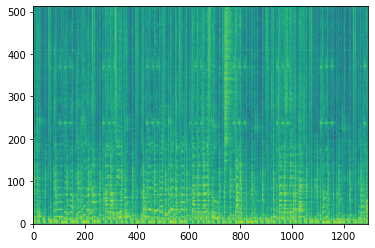

In [14]:
import matplotlib.pyplot as plt
plt.imshow(db_spec[0], origin='lower', aspect='auto')

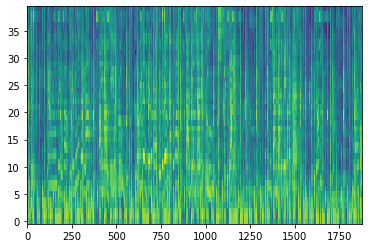

In [15]:
mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=512, n_mels=40, f_max=6000)
# ??torchaudio.transforms.MelSpectrogram

mel_spec = mel_spec_converter(y_ds)
plt.imshow(db_converter(mel_spec[0]), origin='lower', aspect='auto', interpolation='nearest')

- 데이터 로드
1. 미리 오디오를 다 읽어온다 (RAM에 저장)
    - RAM 사이즈가 많이 필요
    
2. 매번 필요할때마다 불러온다 
    - HDD면 느림
    - wav파일이 아닌 다른 압축 오디오의 경우 느림

3. 적당한 파일로 미리 저장해둔다
    - Resample을 해서 용량을 줄인다
    - 멜 스펙트로그램으로 변환해서 저장해논다.

In [69]:
class GTZANDataset:
  def __init__(self, dir_path, split='train'):
    self.dir_path = Path(dir_path)
    self.wave_pths = list(self.dir_path.rglob("*.wav"))
    assert len(self.wave_pths) != 0
    self.genre_names = list(set([x.stem.split('.')[0] for x in self.wave_pths]))
    self.genre_names.sort()
    self.str2idx = {string:idx for idx, string in enumerate(self.genre_names)}
    
    splitted_pths = []
    for pth in self.wave_pths:
      if split=='train' and int(pth.stem.split('.')[1]) < 60:
        splitted_pths.append(pth)
      elif split=='valid' and 60 <= int(pth.stem.split('.')[1]) < 80:
        splitted_pths.append(pth)
      elif split=='test' and int(pth.stem.split('.')[1]) >= 80:
        splitted_pths.append(pth)
    self.wave_pths = splitted_pths

  def __len__(self):
    return len(self.wave_pths)
  
  def __getitem__(self, idx):
    pth = self.wave_pths[idx]
    audio_sample, sr = torchaudio.load(pth)
    genre_str= pth.stem.split('.')[0]
    return audio_sample[0, :sr*29], self.str2idx[genre_str]
  
trainset = GTZANDataset('genres')
validset = GTZANDataset('genres', split='valid')
testset = GTZANDataset('genres', split='test')
# dataset[13].shape[1]/22050
# [dataset[i].shape[1] for i in range(1000
len(trainset), len(validset), len(testset)

(600, 200, 200)

In [62]:
trainset.genre_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [65]:
'''
enumerate 예시
'''
for i, value in enumerate(trainset.genre_names):
  print(i, value)

0 blues
1 classical
2 country
3 disco
4 hiphop
5 jazz
6 metal
7 pop
8 reggae
9 rock


In [68]:
trainset.str2idx['hiphop']

4

In [70]:
trainset[0]

(tensor([ 0.2289,  0.2520,  0.0956,  ..., -0.0729, -0.0984, -0.1690]), 9)

In [50]:
testset.wave_pths

[]

In [41]:
dataset.wave_pths[0].stem

'rock.00016'

In [44]:
int(dataset.wave_pths[0].stem.split('.')[1]) < 60

True

In [37]:
len(dataset)

1000

In [75]:
from torch.utils.data import DataLoader

dataloader = DataLoader(trainset, batch_size=16, shuffle=True)

In [76]:
for batch in dataloader:
  audio, label = batch
  print(label)
  break

tensor([0, 4, 6, 9, 9, 1, 8, 3, 2, 3, 2, 7, 8, 3, 2, 7])


In [30]:
'''
10개의 time bin을 볼 때, 여기에 포함된 전체 샘플의 수
'''
hop_size = 512
n_fft = 1024

'''
1번째의 샘플 수: 512
2번째 까지의 샘플 수: 512 + 256
3번째 까지의 샘플 수: 512 + 256 + 256
'''
num_total_samples = n_fft + (10-1) * hop_size
in_second = num_total_samples / 16000
in_second

0.352

In [79]:
import torch.nn as nn
import torch
class GenreModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.num_frame = 30
    self.n_mels = 40
    
    self.mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=1024, n_mels=self.n_mels, f_max=6000)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

    
    self.nn_layer = nn.Sequential(
                    nn.Linear(self.n_mels*self.num_frame, 128), # input layer. take input and return hidden representation
                    nn.ReLU(),
                    nn.Linear(128, 64), # hidden layer. 
                    nn.ReLU(),
                    nn.Linear(64, 10),  # output layer 
    )
    
  def forward(self, x):
    spec = self.mel_spec_converter(x)
    db_spec = self.db_converter(spec)
#     print(db_spec.shape)
    sliced_spec = db_spec[:,:,db_spec.shape[2]//2:db_spec.shape[2]//2+self.num_frame]
#     print('before flattening', sliced_spec.shape)
    sliced_spec = sliced_spec.reshape(x.shape[0], -1) # -1은 남는 디멘션을 자동으로 계산. 전체 element가 3200이고 0번째 dim 8이면 남은 1번째 디멘션은 자동으로 400
#     print('after flattening', sliced_spec.shape)

    out = self.nn_layer(sliced_spec)
    
    return torch.softmax(out, dim=-1)
  
model = GenreModel()
audio, label = batch
out = model(audio)
out[:4], label[:4]

(tensor([[0.0323, 0.2550, 0.1550, 0.0180, 0.1166, 0.1640, 0.0605, 0.0405, 0.1413,
          0.0168],
         [0.0376, 0.3022, 0.4272, 0.0233, 0.0617, 0.0740, 0.0027, 0.0286, 0.0202,
          0.0225],
         [0.0272, 0.3114, 0.3548, 0.0779, 0.0471, 0.1204, 0.0051, 0.0123, 0.0301,
          0.0137],
         [0.0448, 0.1400, 0.2244, 0.1973, 0.0232, 0.2011, 0.0103, 0.0253, 0.0617,
          0.0718]], grad_fn=<SliceBackward0>),
 tensor([0, 4, 6, 9]))

In [81]:
out[torch.arange(len(label)), label]
'''
torch.arange(3) = [0, 1, 2]
label_wiht_length_3 = [6, 4, 1]

out[torch.arange(3), label_with_length_3] ==
  a = torch.arange(3)
  b = label_with_length_3
  out[a[0], b[0]]
  out[a[1], b[1]]
  out[a[2], b[2]]
'''

tensor([0.0323, 0.0617, 0.0051, 0.0718, 0.0446, 0.0626, 0.0408, 0.1462, 0.2308,
        0.0432, 0.2657, 0.0141, 0.0811, 0.2182, 0.0926, 0.0081],
       grad_fn=<IndexBackward0>)

In [78]:
torch.set_printoptions(sci_mode=False)

In [36]:
out[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

## Make Train Loop

In [85]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(validset, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, num_workers=4, pin_memory=True)

In [83]:
def get_nll(pred, target, eps=1e-6):
  pred_value_for_correct_class = pred[torch.arange(len(target)), target]
  nll_value = -torch.log(pred_value_for_correct_class + eps)
  return torch.mean(nll_value)

get_nll(out, label)

tensor(2.9095, grad_fn=<MeanBackward0>)

In [96]:
def validate_model(model, data_loader, device):
  val_loss = 0
  with torch.no_grad():
    for batch in data_loader:
      audio, label = batch
      prediction = model(audio.to(device))
      loss = get_nll(prediction, label)
      val_loss += loss.cpu().item() * len(label)
  return val_loss / len(data_loader.dataset)

In [99]:
from tqdm import tqdm

device = 'cuda' # or 'cpu'
model = GenreModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

num_epochs=50
loss_record = [] 
val_loss_record = []

for epoch in tqdm(range(num_epochs)):
  for batch in train_loader:
    audio, label = batch
    prediction = model(audio.to(device))
    loss = get_nll(prediction, label)
    loss.backward() # backprop and calculate gradient
    
    optimizer.step() # update parameters
    optimizer.zero_grad() # reset gradient
    loss_record.append(loss.item())

  val_loss = validate_model(model, valid_loader, device=device)
  val_loss_record.append(val_loss)
  

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:04<00:00,  2.49s/it]


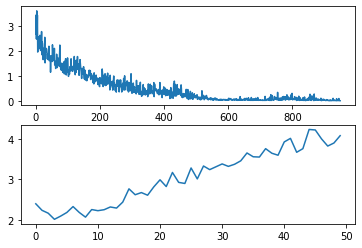

In [100]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(loss_record)
plt.subplot(2,1,2)
plt.plot(val_loss_record)

In [20]:
test = torch.arange(48).reshape(6,8)
test

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31],
        [32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47]])

In [21]:
test.reshape(8,6)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47]])

In [22]:
test.reshape(12,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]])